# RL for Sum of Discounted Reward
- Lagrange RL
    + dense: $\ell(s^+)-\ell(s) + g(s^+)-g(s)$
    + sparse: +50, -50

In [1]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

from gym_reachability import gym_reachability  # Custom Gym env.
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from collections import namedtuple

from KC_DQN.DDQN import DDQN
from KC_DQN.config import dqnConfig

In [2]:
#== CONFIGURATION ==
env_name = "zermelo_kc-v0"
print('='*4 + ' CONFIGURATION ' + '='*4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CONFIG = dqnConfig(DEVICE=device, BATCH_SIZE=200, ENV_NAME=env_name, MAX_EPISODES=20000, MAX_EP_STEPS=100, MEMORY_CAPACITY=20000,
                   GAMMA_PERIOD=40000,
                   EPS_PERIOD=1000, EPS_DECAY=0.6,
                   LR_C_PERIOD=2000, LR_C_DECAY=0.8)
for key, value in CONFIG.__dict__.items():
    if key[:1] != '_': 
        print(key, ': ', value)

==== CONFIGURATION ====
MAX_EPISODES :  20000
MAX_EP_STEPS :  100
EPSILON :  0.95
EPS_END :  0.05
EPS_PERIOD :  1000
EPS_DECAY :  0.6
LR_C :  0.01
LR_C_PERIOD :  2000
LR_C_DECAY :  0.8
MEMORY_CAPACITY :  20000
BATCH_SIZE :  200
GAMMA :  0.9
GAMMA_PERIOD :  40000
GAMMA_DECAY :  0.5
TAU :  0.01
HARD_UPDATE :  1
SOFT_UPDATE :  True
RENDER :  False
ENV_NAME :  zermelo_kc-v0
MAX_MODEL :  5
DEVICE :  cpu
DOUBLE :  True


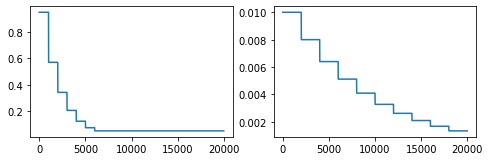

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(8,2.4))

eps = np.zeros(CONFIG.MAX_EPISODES)
lr = np.zeros(CONFIG.MAX_EPISODES)
eps_tmp = CONFIG.EPSILON
lr_tmp = CONFIG.LR_C
for i in range(CONFIG.MAX_EPISODES):
    if i != 0 and i % CONFIG.EPS_PERIOD == 0:
        eps_tmp *= CONFIG.EPS_DECAY
    if i != 0 and i % CONFIG.LR_C_PERIOD == 0:
        lr_tmp *= CONFIG.LR_C_DECAY
    eps[i] = max(eps_tmp, 0.05)
    lr[i] = lr_tmp
ax[0].plot(np.arange(CONFIG.MAX_EPISODES), eps)
ax[1].plot(np.arange(CONFIG.MAX_EPISODES), lr)

In [4]:
# == Environment ==
vmin=-50
vmax=50
env = gym.make(env_name, device=device)
env.set_costParam(vmax, vmin, 'imp_ell_g')

# == Discretization ==
grid_cells = (41, 121)
num_states = np.cumprod(grid_cells)[-1]
state_bounds = env.bounds
env.set_discretization(grid_cells, state_bounds)
print(env.spec.id)

s_dim = env.observation_space.shape[0]
action_num = env.action_space.n
print(s_dim, action_num)

action_list = np.arange(action_num)

zermelo_kc-v0
2 3


/Users/kaichieh/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep[  0] - [0.95/0.900/1.0e-02]: Running cost: 3.93 	 Real cost: 39.32


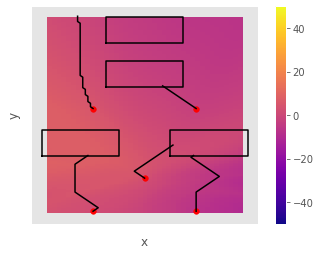

Ep[5000] - [0.07/0.900/6.4e-03]: Running cost: -18.20 	 Real cost: -51.06


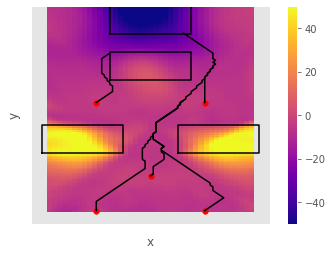

 At Ep[5015] Solved! Running cost is now -45.11!


In [5]:
#== AGENT ==
agent = DDQN(s_dim, action_num, CONFIG, action_list)
training_records = agent.learn(env, MAX_EPISODES=CONFIG.MAX_EPISODES, MAX_EP_STEPS=CONFIG.MAX_EP_STEPS,
                               running_cost_th=vmin*0.9, report_period=5000, vmin=vmin, vmax=vmax)

[[-5.15590143 -3.82047319 -2.92518425 ... -6.79700279 -6.92642784
  -7.03355217]
 [-7.60162973 -6.79204988 -5.68746424 ... -7.42116356 -7.48673439
  -7.54620552]
 [-8.99358082 -8.46304989 -7.91735888 ... -7.97755241 -8.03137398
  -8.08865929]
 ...
 [-4.0424943  -4.6072793  -4.74610376 ... -3.23631096 -3.27126503
  -3.323946  ]
 [-3.57372904 -3.50020838 -3.01491404 ... -2.83728695 -2.85542488
  -2.89305687]
 [-2.97995615 -2.33033228 -1.68476737 ... -2.42336082 -2.4295969
  -2.45722008]]


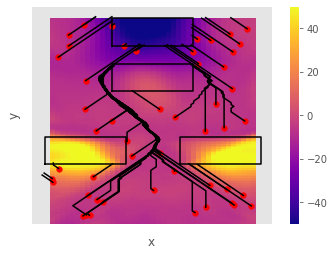

In [10]:
print(env.get_value(agent.Q_network))
env.visualize_analytic_comparison(agent.Q_network, True, vmin=vmin, vmax=vmax)
env.plot_trajectories(agent.Q_network, T=100, num_rnd_traj=50, keepOutOf=True)

##### 